In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import monai
import matplotlib.pyplot as plt
import time
from matplotlib.colors import ListedColormap
from einops import rearrange
from oracle.models.transformer_encoder import VisionTransformer
from oracle.models.transformer_decoder import SegmentationTransformer
from oracle.models.transformer_segmenter import MultiResSegmenter
from oracle.image_utils import convert_1d_index_to_2d, convert_scale_to_coords_in_full_res, convert_1d_patched_index_to_2d_org_index


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
data_img_path = r'D:\Datasets\Decathlon\Task03_Liver\imagesTr\liver_16.nii.gz'
data_label_path = r'D:\Datasets\Decathlon\Task03_Liver\labelsTr\liver_16.nii.gz'
#data_img_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/imagesTr/liver_16.nii.gz"
#data_label_path = "/media/david/T7/Decathlon/Dataset/Task03_Liver/labelsTr/liver_16.nii.gz"

data_file = {'image': data_img_path, 'label': data_label_path}

In [4]:
load_im = monai.transforms.LoadImaged(keys=['image', 'label'])
chan_f = monai.transforms.EnsureChannelFirstD(keys=['image', "label"])
scale_intens = monai.transforms.ScaleIntensityRanged(keys='image', a_min=-21, a_max=189, b_min=0, b_max=1,clip=True)
to_t = monai.transforms.ToTensord(keys=["image", "label"])

data = to_t(scale_intens(chan_f(load_im(data_file))))

In [5]:
slice_max = 423

In [6]:
inputs = data['image'][:,:,:,slice_max].unsqueeze(0).to(device)
labels = data['label'][:,:,:,slice_max].unsqueeze(0).to(device)

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def visualize_data(im, lab):
    plt.figure()
    if im is not None:
        plt.imshow(im.squeeze().cpu().numpy(), cmap='gray')
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    else:
        plt.imshow(lab.squeeze().cpu().numpy(), interpolation='none')

In [9]:
def visualize_patches_scale(patches_scale_coords, n_scales, initial_patch_size, image_size, org_image=None, labels=None):
    colormap = ListedColormap(['silver', 'chocolate', 'blue', 'green', 'orange', 'magenta', 'red', 'lime'])
    full_image = torch.zeros(image_size[0] * image_size[1])
    for scale in range(n_scales):
        patch_size = initial_patch_size // 2**scale
        indx_curr_scale = patches_scale_coords[:, 0] == scale
        coords_at_curr_scale = patches_scale_coords[indx_curr_scale, 1]
        coords_at_org_scale = convert_scale_to_coords_in_full_res(coords_at_curr_scale, patch_size, image_size[0])
        full_image[coords_at_org_scale] = scale
    full_image = full_image.view(image_size[0], image_size[1])
    if org_image is not None:
        plt.imshow(org_image.squeeze().cpu().numpy(), cmap='gray')
    if labels is not None:
        plt.imshow(labels.squeeze().cpu().numpy(), interpolation='none', alpha=0.33)
    plt.imshow(full_image.squeeze().cpu().numpy(), interpolation='none', alpha=0.9, cmap=colormap)


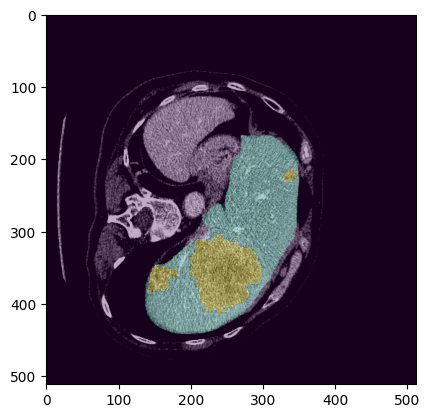

In [10]:
visualize_data(inputs, labels)

In [11]:
def create_oracle_labels(labels, patch_size): 
    max = F.max_pool2d(labels.float(), patch_size, stride=patch_size).to(torch.int32)
    min = F.max_pool2d(-labels.float(), patch_size, stride=patch_size).to(torch.int32)
    one_class = (max == -min)
    
    patch_groups_per_img = one_class.to(torch.uint8)
    
    return patch_groups_per_img.to(torch.long).squeeze(0)

In [25]:
patch_sizes_used = [128, 64, 32, 16, 8, 4, 2]
oracle_labels_multires = []
for ps in patch_sizes_used:
    ol = create_oracle_labels(labels, ps)
    #visualize_data(None, ol)
    oracle_labels_multires.append(ol)
    #print(ol.shape)
    #print(ol.sum())


#oracle_labels = create_oracle_labels(labels, 64)
#visualize_data(inputs, oracle_labels)

In [28]:
d_encoder = 64
n_encoder_layers = 7
patch_size = 128
image_size = (inputs.shape[2], inputs.shape[3])

model = MultiResSegmenter(image_size=image_size,
                          patch_size=patch_size,
                          n_layers_encoder=n_encoder_layers,
                          d_encoder=d_encoder,
                          d_ff_encoder=d_encoder*4,
                          n_heads_encoder=4,
                          n_layers_decoder=2,
                          d_decoder=64,
                          d_ff_decoder=256,
                          n_heads_decoder=4,
                          n_scales=7)

model = model.to(device)
print(model)
print("Total parameters: {}".format(count_parameters(model)))
print("Encoder parameters: {}".format(count_parameters(model.encoder)))
print("Decoder parameters: {}".format(count_parameters(model.decoder)))

MultiResSegmenter(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(1, 64, kernel_size=(128, 128), stride=(128, 128))
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (rel_pos_embs): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x4x64 (cuda:0)]
        (1): Parameter containing: [torch.float32 of size 1x4x64 (cuda:0)]
        (2): Parameter containing: [torch.float32 of size 1x4x64 (cuda:0)]
        (3): Parameter containing: [torch.float32 of size 1x4x64 (cuda:0)]
        (4): Parameter containing: [torch.float32 of size 1x4x64 (cuda:0)]
    )
    (blocks): ModuleList(
      (0-5): 6 x Block(
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=64, out_features=192, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=

Number of tokens after encoder: 976
Epoch: 99, Dice score: 0.7463, loss: 0.5622, lr: 0.0010, epoch_time: 0.0925
Epoch: 199, Dice score: 0.8553, loss: 0.4274, lr: 0.0009, epoch_time: 0.0892
Epoch: 299, Dice score: 0.8987, loss: 0.3498, lr: 0.0008, epoch_time: 0.0896
Epoch: 399, Dice score: 0.9217, loss: 0.3047, lr: 0.0007, epoch_time: 0.0946
Epoch: 499, Dice score: 0.9357, loss: 0.2751, lr: 0.0005, epoch_time: 0.0865
Epoch: 599, Dice score: 0.9450, loss: 0.2560, lr: 0.0003, epoch_time: 0.0936
Epoch: 699, Dice score: 0.9517, loss: 0.2445, lr: 0.0002, epoch_time: 0.0895
Epoch: 799, Dice score: 0.9567, loss: 0.2384, lr: 0.0001, epoch_time: 0.1545
Epoch: 899, Dice score: 0.9606, loss: 0.2361, lr: 0.0000, epoch_time: 0.1515
Epoch: 999, Dice score: 0.9638, loss: 0.2358, lr: 0.0000, epoch_time: 0.1460


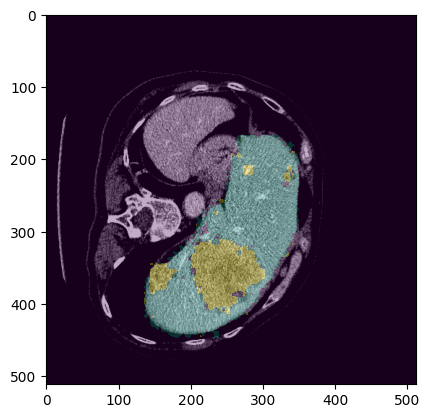

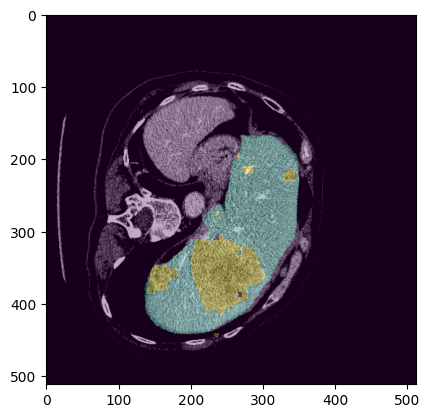

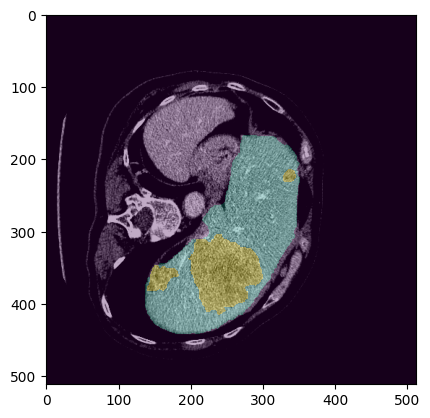

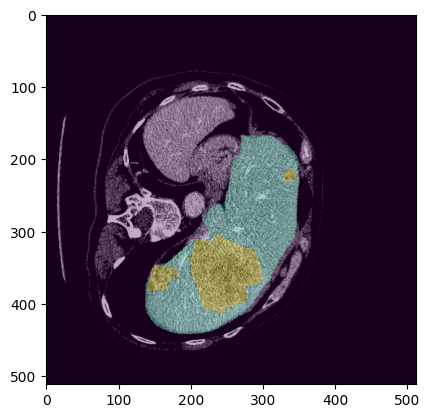

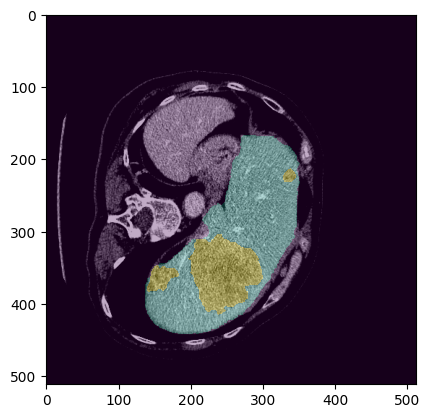

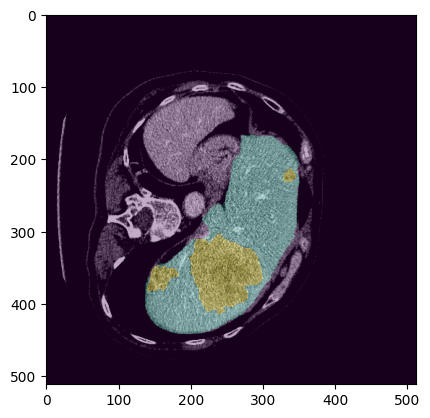

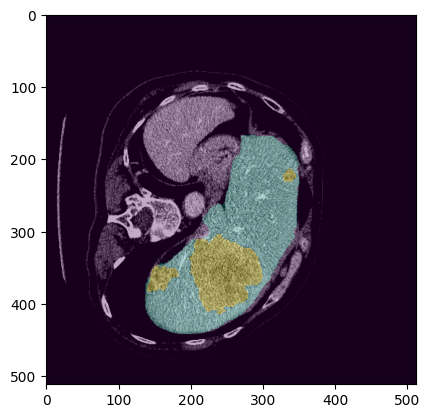

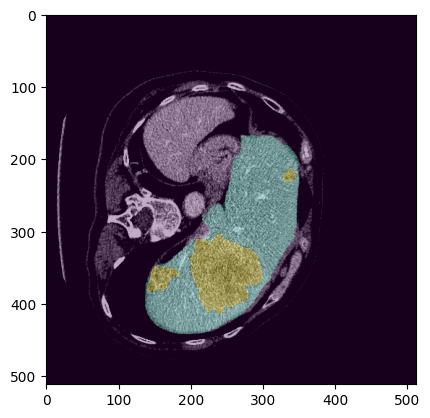

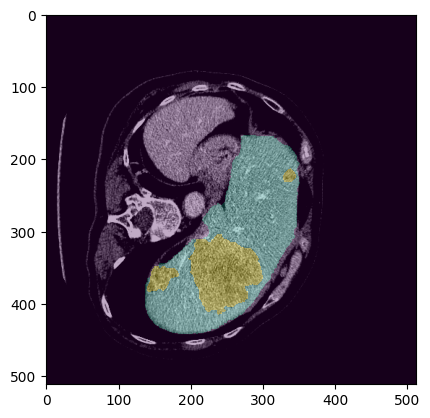

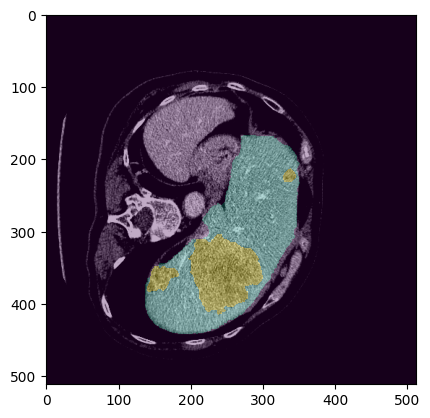

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = monai.losses.DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=False)
post_label = monai.transforms.AsDiscrete(to_onehot=3)
post_pred = monai.transforms.AsDiscrete(argmax=True, to_onehot=3)
dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean", get_not_nans=True)
epochs = 1000
total_prints = 10
print_every_n_epochs = epochs // total_prints
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

with torch.no_grad():
    _, enc_out, _ = model(inputs, oracle_labels_multires)
    print("Number of tokens after encoder: {}".format(enc_out.shape[1]))


for e in range(epochs):
    epoch_start = time.time()
    outputs, _, patches_scale_coords = model(inputs, oracle_labels_multires)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    labels_convert = [post_label(labels[0])]
    output_convert = [post_pred(outputs[0])]
    dice_metric(y_pred=output_convert, y=labels_convert)
    dice_scores, dice_not_nans = dice_metric.aggregate()
    epoch_time = time.time() - epoch_start
    if ((e + 1) % print_every_n_epochs) == 0:
        print("Epoch: {}, Dice score: {:.4f}, loss: {:.4f}, lr: {:.4f}, epoch_time: {:.4f}".format(e, dice_scores.item(), loss.item(), scheduler.get_last_lr()[0], epoch_time))
        pred = torch.argmax(outputs, dim=1)
        visualize_data(inputs, pred)
    scheduler.step()


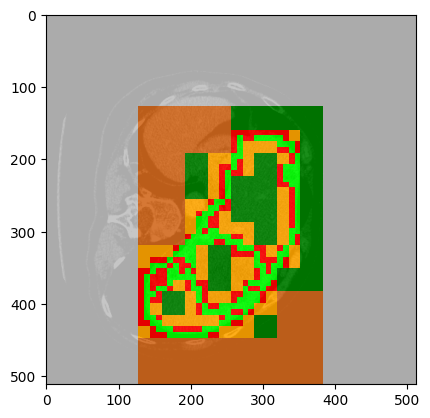

In [30]:
visualize_patches_scale(patches_scale_coords, n_encoder_layers, patch_size, image_size, inputs)